In [1]:
# 工具函数
import os
import sys
import random
from pathlib import Path
import pickle
!pip install easydict
from easydict import EasyDict

# 数据处理与可视化
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
%matplotlib inline

# 图像处理
import cv2
from PIL import Image

# 深度学习
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam, SGD
import torchvision.models as models
from torch.nn.parameter import Parameter
from torch.utils.data import DataLoader, Dataset
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts, CosineAnnealingLR, ReduceLROnPlateau
from torch.optim.swa_utils import AveragedModel, update_bn
import pytorch_lightning as pl
from pytorch_lightning import loggers

# pytorch_lightning 日志可视化
!pip install git+https://github.com/percevalw/rich_logger.git
from rich_logger import RichTablePrinter, RichTableLogger

# 预训练视觉模型库 版本 0.4.13
import timm

# 图像增强
from albumentations import (
    Compose, OneOf, Normalize, Resize, RandomResizedCrop, RandomCrop, HorizontalFlip, VerticalFlip, 
    RandomBrightness, RandomContrast, RandomBrightnessContrast, Rotate, ShiftScaleRotate, Cutout, 
    IAAAdditiveGaussianNoise, Transpose
    )
from albumentations.pytorch import ToTensorV2

  Cloning https://github.com/percevalw/rich_logger.git to /tmp/pip-req-build-w17mzdgz
  Running command git clone -q https://github.com/percevalw/rich_logger.git /tmp/pip-req-build-w17mzdgz


In [2]:
# 随机数，确保模型可复现
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True
    

seed_everything(1024)

In [3]:
class ClassificationDataset(Dataset):

    def __init__(self, images, labels, transform):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, item):
        image = self.transform(image=self.images[item])["image"]
        label = torch.tensor(self.labels[item]).long()
        return image, label

def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        d = pickle.load(fo, encoding='bytes')
    return d


def get_mnist_transform(mode="train"):
    
    if mode == "train":
        transform = Compose([
            VerticalFlip(p=0.5), HorizontalFlip(p=0.5), Resize(224, 224), Normalize(mean=[33.4 / 255], std=[78.69 / 255]), ToTensorV2()])
    else:
        transform = Compose([
            Resize(224, 224), 
            Normalize(mean=[33.4], std=[78.69]), 
            ToTensorV2()])
    return transform

In [31]:
class Net(pl.LightningModule):

    def __init__(self, model_name_or_path, n_class, pretrained=True, in_chans=3, checkpoint=None, 
                 backbone_lr=1e-5, head_lr=1e-3, optimizer="Adam"):
        # efficientnet_b0
        super().__init__()
        self.backbone = timm.create_model(model_name_or_path, pretrained=pretrained,
                                           in_chans=in_chans, checkpoint_path=checkpoint, num_classes=0)
        self.head = nn.Linear(self.backbone.num_features, n_class)
        self.loss_fn = nn.CrossEntropyLoss()
        self._optimizer = optimizer
        self._backbone_lr = backbone_lr
        self._head_lr = head_lr
#         if pretrained:
#             for p in self.backbone.parameters():
#                 p.requires_grad = False

    def forward(self, x):
        x = self.backbone(x)
        x = self.head(x)
        return x

    def configure_optimizers(self):
        if self._optimizer == "Adam":
            optimizer = torch.optim.Adam([{"params": self.backbone.parameters(), "lr": self._backbone_lr},
                                         {"params": self.head.parameters(), "lr": self._head_lr}], 
                                         lr=self._head_lr, weight_decay=5e-4,)
        else:
            optimizer = torch.optim.SGD(
            [{"params": self.backbone.parameters(), "lr": self._backbone_lr},
                                         {"params": self.head.parameters(), "lr": self._head_lr}],
            lr=self._head_lr,
            momentum=0.9,
            weight_decay=5e-4,
        )
        lr_scheduler = ReduceLROnPlateau(optimizer, verbose=True)
        return {"optimizer": optimizer, "lr_scheduler": lr_scheduler, "monitor": "val_loss"}

    def training_step(self, train_batch, batch_idx):
        x, y = train_batch
        pred = self(x)
        loss = self.loss_fn(pred, y)
        acc = accuracy_score(y.cpu().numpy(), torch.argmax(pred, 1).cpu().numpy())
        tensorboard_logs = {"train_loss": loss, "train_acc": acc}
        self.log_dict(tensorboard_logs)
        return loss

    def validation_step(self, val_batch, batch_idx):
        x, y = val_batch
        pred = self(x)
        loss = self.loss_fn(pred, y)
        acc = accuracy_score(y.cpu().numpy(), torch.argmax(pred, 1).cpu().numpy())
        tensorboard_logs = {"val_loss": loss, "val_acc": acc}
        self.log_dict(tensorboard_logs)
        return loss

# CIFAR 10数据集

http://www.cs.toronto.edu/~kriz/cifar.html

In [32]:
!tree /home/kky/data/cifar-10-batches-py

/home/kky/data/cifar-10-batches-py
├── batches.meta
├── data_batch_1
├── data_batch_2
├── data_batch_3
├── data_batch_4
├── data_batch_5
├── readme.html
└── test_batch

0 directories, 8 files


In [33]:
!tree /home/kky/data/cifar-100-python/

/home/kky/data/cifar-100-python/
├── file.txt~
├── meta
├── test
└── train

0 directories, 4 files


In [34]:
def load_cifar100(path, label=b"fine_labels"):
    # label: fine_labels[100] or b'coarse_labels[20]
    data = unpickle(Path(path) / "train")
    train_images = data[b'data'].reshape(-1, 3, 32, 32).transpose(0, 2, 3, 1) # (sample, width, hight, channel)
    train_labels = data[b'fine_labels']
    
    data = unpickle(Path(path) / "test")
    val_images = data[b'data'].reshape(-1, 3, 32, 32).transpose(0, 2, 3, 1) # (sample, width, hight, channel)
    val_labels = data[b'fine_labels']
    return train_images, train_labels, val_images, val_labels


def load_cifar10(path):
    train_images = []
    train_labels = []
    for batch in range(1, 6):
        data = unpickle(Path(path) / f"data_batch_{batch}")
        images = data[b'data'].reshape(-1, 3, 32, 32).transpose(0, 2, 3, 1) # (sample, width, hight, channel)
        labels = data[b'labels']
        train_images.append(images)
        train_labels.append(labels)
    
    data = unpickle(Path(path) / f"test_batch")
    val_images = data[b'data'].reshape(-1, 3, 32, 32).transpose(0, 2, 3, 1) # (sample, width, hight, channel)
    val_labels = data[b'labels']
    return np.concatenate(train_images, axis=0), np.concatenate(train_labels, axis=0), val_images, val_labels

In [35]:
def random_plot(images, labels):
    
    plt.figure(figsize=(8, 8))
    selected = np.random.choice(range(0, len(labels)), 16, False)
    for i in range(16):
        plt.subplot(4, 4, i+1)
        plt.imshow(images[selected[i]])
        plt.title(f"label: {labels[selected[i]]}")
    plt.show()

# Config

# CIFAR 10 

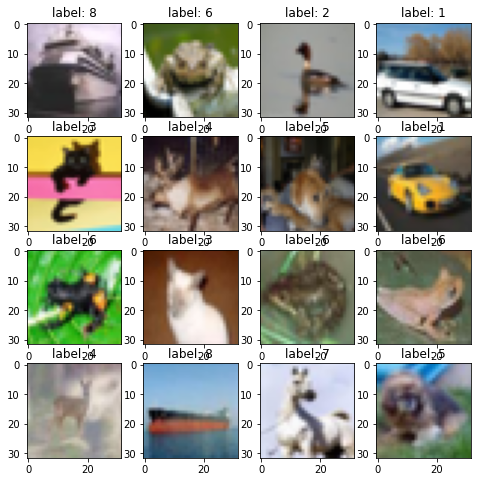

In [36]:
trn_x, trn_y, val_x, val_y = load_cifar10("/home/kky/data/cifar-10-batches-py")
random_plot(trn_x, trn_y)

In [ ]:
def get_cifar_transform(mode="train"):
    if mode == "train":
        transform = Compose([VerticalFlip(p=0.5), 
                             HorizontalFlip(p=0.5), 
#                              Resize(380, 380),  # for B4
                             Resize(224, 224),  # for B0
                             Normalize([0.49137255, 0.48235294, 0.44666667], [0.24705882, 0.24352941, 0.26156863]), 
                             ToTensorV2()])
    else:
        transform = Compose([
            # Resize(380, 380),  # for B4
            Resize(224, 224),  # for B0
            Normalize([0.49137255, 0.48235294, 0.44666667], [0.24705882, 0.24352941, 0.26156863]), 
            ToTensorV2()])
    return transform


config = {
    
    "output_path": "/cache/image_classification/cifar10_effnb0",
    
    # model
    "model": {"model_name_or_path": "efficientnet_b0", "n_class": 10, "pretrained": True, 
              "in_chans": 3, "head_lr": 1e-2, "backbone_lr": 1e-5, "optimizer": "SGD"},
    
    # data
    "data_loader": {"batch_size": 256, "num_workers": 8},
    
    # trainer
    "trainer": {"gpus": [0], "max_epochs": 30, "log_every_n_steps": 40, "val_check_interval": 40,},
    
    # callbacks
    "early_stopping": {"monitor": "val_acc", "min_delta": 5e-5, "patience": 5, "mode": "max"},
    
}

C = EasyDict(config)

trn_ds = ClassificationDataset(trn_x, trn_y, get_cifar_transform("train"))
val_ds = ClassificationDataset(val_x, val_y, get_cifar_transform("val"))

trn_dl = DataLoader(trn_ds, shuffle=True, **C.data_loader)
val_dl = DataLoader(val_ds, shuffle=False, **C.data_loader)

model = Net(**C.model)
#model.conv1 = nn.Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
#model.maxpool = nn.Identity()

callbacks = [pl.callbacks.EarlyStopping(**C.early_stopping),
            pl.callbacks.ModelCheckpoint(C.output_path, monitor="val_acc", save_top_k=3),
            ]
logger_fields = {
    "epoch": {},
    "step": {},
    "train_loss": {"goal": "lower_is_better", "format": "{:.4f}", "name": r"train_loss"},
    "train_acc": {"goal": "higher_is_better", "format": "{:.4f}", "name": r"train_acc"},
    "val_loss": {"goal": "lower_is_better", "format": "{:.4f}", "name": r"val_loss"},
    "val_acc": {"goal": "higher_is_better", "format": "{:.4f}", "name": r"val_acc"},
}
logger = [RichTableLogger(key="epoch", fields=logger_fields), loggers.CSVLogger(C.output_path, "csg_logger")]
trainer = pl.Trainer(**C.trainer, callbacks=callbacks, logger=logger, default_root_dir=C.output_path)
trainer.fit(model, trn_dl, val_dl)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name     | Type             | Params
----------------------------------------------
0 | backbone | EfficientNet     | 4.0 M 
1 | head     | Linear           | 12.8 K
2 | loss_fn  | CrossEntropyLoss | 0     
----------------------------------------------
4.0 M     Trainable params
0         Non-trainable params
4.0 M     Total params
16.081    Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: -1it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

# CIFAR10 - Vit

vit_base_patch16_224

In [12]:
def get_cifar_transform(mode="train"):
    if mode == "train":
        transform = Compose([VerticalFlip(p=0.5), 
                             HorizontalFlip(p=0.5), 
                             Resize(224, 224), 
                             Normalize([0.49137255, 0.48235294, 0.44666667], [0.24705882, 0.24352941, 0.26156863]), 
                             ToTensorV2()])
    else:
        transform = Compose([
            Resize(224, 224), 
            Normalize([0.49137255, 0.48235294, 0.44666667], [0.24705882, 0.24352941, 0.26156863]), 
            ToTensorV2()])
    return transform


config = {
    
    "output_path": "/cache/image_classification/vit_base_patch16_224",
    
    # model
    "model": {"model_name_or_path": "vit_base_patch16_224", "n_class": 10, "pretrained": True, 
              "in_chans": 3, "head_lr": 1e-2, "backbone_lr": 1e-5},
    
    # data
    "data_loader": {"batch_size": 256, "num_workers": 16},
    
    # trainer
    "trainer": {"gpus": [0], "max_epochs": 30, "log_every_n_steps": 40,  "val_check_interval": 40},
    
    # callbacks
    "early_stopping": {"monitor": "val_acc", "min_delta": 5e-5, "patience": 5, "mode": "max"},
    
}

C = EasyDict(config)

trn_ds = ClassificationDataset(trn_x, trn_y, get_cifar_transform("train"))
val_ds = ClassificationDataset(val_x, val_y, get_cifar_transform("val"))

trn_dl = DataLoader(trn_ds, shuffle=True, **C.data_loader)
val_dl = DataLoader(val_ds, shuffle=False, **C.data_loader)

model = Net(**C.model)
#model.conv1 = nn.Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
#model.maxpool = nn.Identity()

callbacks = [pl.callbacks.EarlyStopping(**C.early_stopping),
            pl.callbacks.ModelCheckpoint(C.output_path, monitor="val_acc", save_top_k=3)]
logger_fields = {
    "step": {},
    "train_loss": {"goal": "lower_is_better", "format": "{:.4f}", "name": r"train_loss"},
    "train_acc": {"goal": "higher_is_better", "format": "{:.4f}", "name": r"train_acc"},
    "val_loss": {"goal": "lower_is_better", "format": "{:.4f}", "name": r"val_loss"},
    "val_acc": {"goal": "higher_is_better", "format": "{:.4f}", "name": r"val_acc"},
}
logger = [RichTableLogger(key="epoch", fields=logger_fields), loggers.CSVLogger(C.output_path, "csv_logger")]
trainer = pl.Trainer(**C.trainer, callbacks=callbacks, logger=logger, default_root_dir=C.output_path)
trainer.fit(model, trn_dl, val_dl)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name     | Type              | Params
-----------------------------------------------
0 | backbone | VisionTransformer | 85.8 M
1 | head     | Linear            | 7.7 K 
2 | loss_fn  | CrossEntropyLoss  | 0     
-----------------------------------------------
7.7 K     Trainable params
85.8 M    Non-trainable params
85.8 M    Total params
343.225   Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: -1it [00:00, ?it/s]

/home/kky/miniconda3/envs/torch170/lib/python3.7/site-packages/pytorch_lightning/trainer/trainer.py:1047: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")
